# Publish the Model

In this notebook, we aim to deploy the registered model from the ML Pipeline task.

In the previous step, we manage to create an ML pipeline and run it from the DevOps Build Pipeline. To make that possible, we leveraged Service Principle Identities to log in into our Azure Account from the application to access the ML Workspace. In this notebook, we don't follow this but the Python version of this notebook (located at Score/deploy_model.py) uses the same log-in mechanism, as we need to run the  from the Release Pipeline.

To register the model we follow these steps:
1. Log in to Azure and get a hold on the Workspace
1. Get the latest registered model from the Model Store
1. Create a container image from the model
1. Create a Kubernetes cluster
1. Deploy the image as a Web Service into the Kubernetes
1. Test whether the model is working as expected behind the WebService within the Kubernetes cluster
1. Convert this notebook into Python and register it into the Release Pipeline

**Important Note:**:
Similar to other notebooks, here are the requirements to run this notebook:

In order to practice all parts of the following Notebook, you first need to get a free Azure credit. If you don't have it, you can simply obtain it through this link: https://azure.microsoft.com/en-us/free/

You can run this notebook on your local latop, Azure Notebooks (notebooks.azure.com) or Notebook VMs:
- Local Laptop - the following packages has to be installed:
    - Azureml-SDK - with notebook,widget extensions
    - tensorflow==1.13
- Azure Notebooks:
    - This is a free notebook, all of the packages for an ML experiment is installed
- AzureML Notebook:
    - This is a premium notebook that you can choose the VM type. Avoid using this feature for the workshop as you may burn your credit before the end or the workshop.

Once you chose the execution environment, you need to create an Azure Machine Learning Service. Follow this instruction to build one:

The following text is copied from: https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-1st-experiment-sdk-setup#create-a-workspace

An Azure Machine Learning workspace is a foundational resource in the cloud that you use to experiment, train, and deploy machine learning models. It ties your Azure subscription and resource group to an easily consumed object in the service.

You create a workspace via the Azure portal, a web-based console for managing your Azure resources.

1. Sign in to the Azure portal by using the credentials for the Azure subscription you use.
1. In the upper-left corner of Azure portal, select + Create a resource.
1. Create a new resource
1. Use the search bar to find Machine Learning service workspace.
1. Select Machine Learning service workspace.
1. In the Machine Learning service workspace pane, select Create to begin.
1. Provide the following information to configure your new workspace:
    - **Field	Description**
    - **Workspace name**: type in **FirstExample**.
    - **Subscription**: Select the Azure subscription that you want to use. (Your free credit)
    - **Resource group**: type in **MLOpsWorkshop**
    - **Location**: type in **westus2**
1. After you are finished configuring the workspace, select Create.
When the process is finished, a deployment success message appears.
1. To view the new workspace, select Go to resource.


You can explore the resource from two view:
1. https://portal.azure.com (you can access all resources including Azure ML)
1. https://ml.azure.com (recently released - still in preview and dedicated to Azure ML)



In [1]:
import azureml.core
from azureml.core import Workspace, Experiment, Datastore
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

from azureml.data.data_reference import DataReference
from azureml.pipeline.core import Pipeline, PipelineData
from azureml.pipeline.steps import PythonScriptStep
from azureml.core.compute import AksCompute
from azureml.core.webservice import Webservice, AksWebservice
from azureml.core.image import ContainerImage

SDK version: 1.0.69
Pipeline SDK-specific imports completed


In [2]:
# Your subscription ID will be different replace the stirng with yours
subscription_id = "<subscription_id>"
resource_group = "MLOpsWorkshop"
workspace_name = "FirstExample"
workspace_region = "westus2"

In [ ]:
# import the Workspace class and check the azureml SDK version
# exist_ok checks if workspace exists or not.

from azureml.core import Workspace

ws = Workspace(workspace_name = workspace_name,
               subscription_id = subscription_id,
               resource_group = resource_group)

# persist the subscription id, resource group name, and workspace name in aml_config/config.json.
ws.write_config()

In [ ]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

### 1. Get the registered model registered in the last session.

You need to make sure the model_name is set property. In order to find out the model_name you registered in the previous session, go to portal.azure.com, click on your Workspace and the from the Asset panel, click on the Models. If you don't see any model registered here, you need to first run the previous lab located at (https://github.com/classicboyir/ml-pipelines/blob/master/MLPipeline_MNIST.ipynb). Clone this repo and follow the instructions.

In [5]:
from azureml.core.model import Model

model_name = "tf_mnist_pipeline_devops.model"
model_root = Model(ws, name=model_name)

### 2. Provide the dependencies required at the inference time.

This code block generates the conda dependency file to load a TF model. You can find the script that is in charge of the inference task. You can check it at here **Score/score.py**.

In [41]:
from azureml.core.runconfig import CondaDependencies

cd = CondaDependencies.create()
cd.add_conda_package('numpy')

# Adds all you need for TF
cd.add_tensorflow_conda_package() # core_type='cpu', version='1.13')
cd.save_to_file(base_directory='./score', conda_file_path='myenv.yml')

print(cd.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults==1.0.69.*
- numpy
- tensorflow=1.13.1
channels:
- conda-forge



### 3. Containerize the model

In this task, it builds a docker image containing the model, the dependency file and also the score.py file. The image is registered at the Images section within your Workspace. You can explore it through portal.azure.com.


In [43]:
%%time
os.chdir('./score')
image_config = ContainerImage.image_configuration(execution_script = "score.py",
                                                  runtime = "python",
                                                  conda_file = "myenv.yml",
                                                  description = "MNIST TF Model",
                                                  tags = {'--release-id': "0", 'type': "TF deployment"})

image = ContainerImage.create(name = "mnist-image-pipeline",
                              # this is the model object
                              models = [model_root],
                              image_config = image_config,
                              workspace = ws)

image.wait_for_creation(show_output = True)

Creating image
Running..........................................
Succeeded
Image creation operation finished for image mnist-image-pipeline:3, operation "Succeeded"
Wall time: 4min 22s


### 4. Creating a Kubernetes Cluster

In this step, we create one Kubernetes cluster to host the dockerized image and provide it through a web service.


In [8]:
%%time

from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException

aks_name = 'aks-deployment'

try:
    kubeconfig = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing AKS service')
except Exception:
    prov_config = AksCompute.provisioning_configuration()

    print('Creating a new AKS service...')
    aks_target = ComputeTarget.create(workspace = ws, 
                                  name = aks_name, 
                                  provisioning_configuration = prov_config)

    aks_target.wait_for_completion(show_output = True)
    print(aks_target.provisioning_state)
    print(aks_target.provisioning_errors)

# use get_status() to get a detailed status for the current cluster. 
print(aks_target.get_status())

Found existing AKS service
Succeeded
Wall time: 1.8 s


### 5. Registering the dockerized image as a Webservice on the Kubernetes cluster

First, we provide the configuration for the web service. We enable app insights to be able to log and monitor the activities of our mode. We can also turn on the auto scaling feature to scale the container as needed.

In [99]:
%%time

#Set the web service configuration (using default here)
aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,
                                                autoscale_min_replicas=1,
                                                autoscale_max_replicas=2,
                                                collect_model_data=True,
                                                enable_app_insights=True)


Wall time: 0 ns


In [103]:
%%time

# In this code block, we register the image under a webservice in Kubernetes cluster:

aks_service_name ='mnist-webapp-service-monitored'

try:
    aks_service = Webservice(name = aks_service_name, workspace = ws)
    print('Found the webservice, deleting the service to add a new one')
    aks_service.delete()
    print('Old webservice is deleted')
except Exception:
    print("This webservice doesn't exist")
finally:
    print('Deploying the new web service')
    aks_service = Webservice.deploy_from_image(workspace = ws, 
                                           name = aks_service_name,
                                           image = image,
                                           deployment_config = aks_config,
                                           deployment_target = aks_target)

    aks_service.wait_for_deployment(show_output = True)
    print('This webservice is deployed')

Found the webservice, deleting the service to add a new one
Old webservice is deleted
Deploying the new web service
SucceededAKS service creation operation finished, operation "Succeeded"
This webservice is deployed
Wall time: 1min 25s


### 6. Testing the Model

After the image which includes the model is registered as a web service, we should now check to see if the model is performing the expected behavior or not. The following code blocks try to download the dataset, pass some randomly selected data to the data to the web service and finally plot the result.


In [15]:
import os
import urllib

os.makedirs('./data/mnist', exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename = './data/mnist/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename = './data/mnist/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename = './data/mnist/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename = './data/mnist/test-labels.gz')


In [106]:
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data('./data/mnist/train-images.gz', False) / 255.0
y_train = load_data('./data/mnist/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/mnist/test-images.gz', False) / 255.0
y_test = load_data('./data/mnist/test-labels.gz', True).reshape(-1)

In [107]:
%matplotlib inline
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

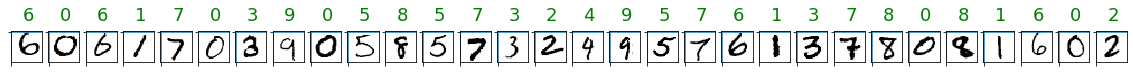

In [139]:
import json
import numpy as np

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = aks_service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'green'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=y_test[s], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1

plt.show()

You can always access the Webservice URL and the authentication keys using the following commands:

In [18]:
aks_service.scoring_uri

'http://52.250.119.122:80/api/v1/service/mnist-web-app/score'

In [19]:
aks_service.get_keys()

('u6ANCIHvFC40VLs1h7bjXObhA1ipnwca', 'YqtjqbslfMTfwW7lRWK2NZ4LU4HRNGYB')